# Predictive Analysis of Impression Ratings Using Classification Algorithms



## Part 0: Install and Load Packages

In [0]:
pip install yfinance

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached yfinance-0.2.37-py2.py3-none-any.whl (72 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached frozendict-2.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (116 kB)
  Using cached peewee-3.17.1-cp310-cp310-linux_x86_64.whl
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Not uninstalling requests at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-4b97ae55-392b-4f1d-997f-c8918862be69
    Can't uninstall 'requests'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflict

In [0]:
pip install xgboost

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
pip install shap

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import shap

## Part 1: Exploratory Data Analysis (EDA)

In this section, we conduct a comprehensive Exploratory Data Analysis (EDA) to gain insights into the dataset.

- ***Data Integrity Checks***: We perform rigorous data integrity checks to ensure the quality and consistency of the dataset. This includes examining data types, unique values, and identifying any missing data.

- ***Description of Numerical Features***: We provide a detailed description of numerical features, such as the "square footage" and "number of buildings" columns. This includes summary statistics and distributions to understand their characteristics better.

- ***Exploration of Categorical Columns***: We delve into categorical columns, investigating unique values such as "location rating" and "property status" to analyze their distributions and potential impact on the target variable.

- ***Time Series Visualization and Distribution Analysis***: We visualize "completion date" frequencies and analyze the temporal distribution of data to identify potential gaps around significant historical events. Sparse data availability before the 1970s is explored through decade-wise completion date counts, providing insights on potential limitations in historical record-keeping.


In [0]:
# Read the .txt file into a DataFrame

df = pd.read_csv('property locations.txt', sep='\t', encoding='latin-1')
df.head()

,PropertyName,Address,City,State,ZipCode,PhoneNumber,TotalSqFt,NetRentableSqFt,TotalAcres,NumBuildings,NumFloors,PropertyStatus,ImpressionRating,LocationRating,CompletionDate
0,720 Self Storage,720 6th Avenue,Troy,NY,12182.0,5.182337e+09,17769.0,15103.0,1.91,3.0,2,Completed,B,C+,1/1/1970
1,A - Metro Climate Controlled Self Storage,4773 Western Turnpike,Altamont,NY,12009.0,5.183579e+09,44268.0,42054.0,10.60,6.0,1,Completed,B,B-,1/1/2013
2,A - Metro Movers Self Storage,889 Troy-Schenectady Road,Latham,NY,12110.0,5.187834e+09,43069.0,36608.0,5.70,6.0,2,Completed,B,B,1/1/1989
3,A - Metro Movers Self Storage,2703 Curry Road,Guilderland,NY,12303.0,5.183555e+09,37125.0,31556.0,4.55,2.0,2,Completed,B,B-,1/1/2011
4,Accessible Self Storage,1233 Route 9,Hudson,NY,12534.0,5.188221e+09,10900.0,10355.0,17.40,4.0,1,Completed,C,C,1/1/2000


In [0]:
# Checking DataFrame information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28723 entries, 0 to 28722
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PropertyName      28723 non-null  object 
 1   Address           28723 non-null  object 
 2   City              28723 non-null  object 
 3   State             28723 non-null  object 
 4   ZipCode           28722 non-null  float64
 5   PhoneNumber       27117 non-null  float64
 6   TotalSqFt         28461 non-null  float64
 7   NetRentableSqFt   28039 non-null  float64
 8   TotalAcres        28722 non-null  float64
 9   NumBuildings      28524 non-null  float64
 10  NumFloors         28723 non-null  int64  
 11  PropertyStatus    28723 non-null  object 
 12  ImpressionRating  28723 non-null  object 
 13  LocationRating    28723 non-null  object 
 14  CompletionDate    27100 non-null  object 
dtypes: float64(6), int64(1), object(8)
memory usage: 3.3+ MB


In [0]:
# Checking the number of unique values

df.nunique()

PropertyName        11515
Address             28277
City                 4414
State                  45
ZipCode              7787
PhoneNumber         25958
TotalSqFt           19983
NetRentableSqFt     20216
TotalAcres           2121
NumBuildings           59
NumFloors              16
PropertyStatus          4
ImpressionRating        4
LocationRating         12
CompletionDate       1653
dtype: int64

In [0]:
# Checking null values

df.isna().sum()

PropertyName           0
Address                0
City                   0
State                  0
ZipCode                1
PhoneNumber         1606
TotalSqFt            262
NetRentableSqFt      684
TotalAcres             1
NumBuildings         199
NumFloors              0
PropertyStatus         0
ImpressionRating       0
LocationRating         0
CompletionDate      1623
dtype: int64

In [0]:
# Calculating counts of each property name

property_counts = df['PropertyName'].value_counts()
property_counts  # some properties have counts much bigger than others

Public Storage                      2568
Extra Space Storage                 2000
U - Haul Moving & Storage           1239
CubeSmart Self Storage              1187
LifeStorage                          906
                                    ... 
Long Beach Storage Center              1
Mt. Olive Self Storage                 1
Nova Storage Phase II                  1
Paramount - Jackson Self Storage       1
US Storage Centers Phase II            1
Name: PropertyName, Length: 11515, dtype: int64

In [0]:
# Describing numerical columns

df[['TotalSqFt', 'NetRentableSqFt', 'TotalAcres', 'NumBuildings', 'NumFloors']].describe()

,TotalSqFt,NetRentableSqFt,TotalAcres,NumBuildings,NumFloors
count,28461.000000,28039.000000,28722.000000,28524.000000,28723.000000
mean,65408.595973,57093.829274,4.948031,7.723671,1.589423
std,42941.710400,35700.946169,9.940328,314.411907,1.073723
min,99.000000,74.000000,0.070000,1.000000,1.000000
25%,34214.000000,31407.000000,2.110000,2.000000,1.000000
50%,59860.000000,53627.000000,3.580000,5.000000,1.000000
75%,88868.000000,76041.000000,5.590000,8.000000,2.000000
max,657743.000000,493307.000000,844.270000,53100.000000,21.000000


In [0]:
# Checking unique values for certain categorical columns

print('ImpressionRating unique values',df['ImpressionRating'].unique())
print('LocationRating unique values',df['LocationRating'].unique())
print('PropertyStatus unique values',df['PropertyStatus'].unique())

ImpressionRating unique values ['B' 'C' 'A' 'NR']
LocationRating unique values ['C+' 'B-' 'B' 'C' 'B+' 'A-' 'A' 'C-' 'A+' 'NR' 'C ' 'A ']
PropertyStatus unique values ['Completed' 'Planned' 'Under Construction' 'Prospective']


In [0]:
# Checking the number of unique values for each ImpressionRating and LocationRating

df['ImpressionRating'].value_counts()
df['LocationRating'].value_counts()

C+    8364
B-    6777
B     4800
C     4029
B+    2522
A-    1277
A      525
C-     348
A+      70
NR       7
C        3
A        1
Name: LocationRating, dtype: int64

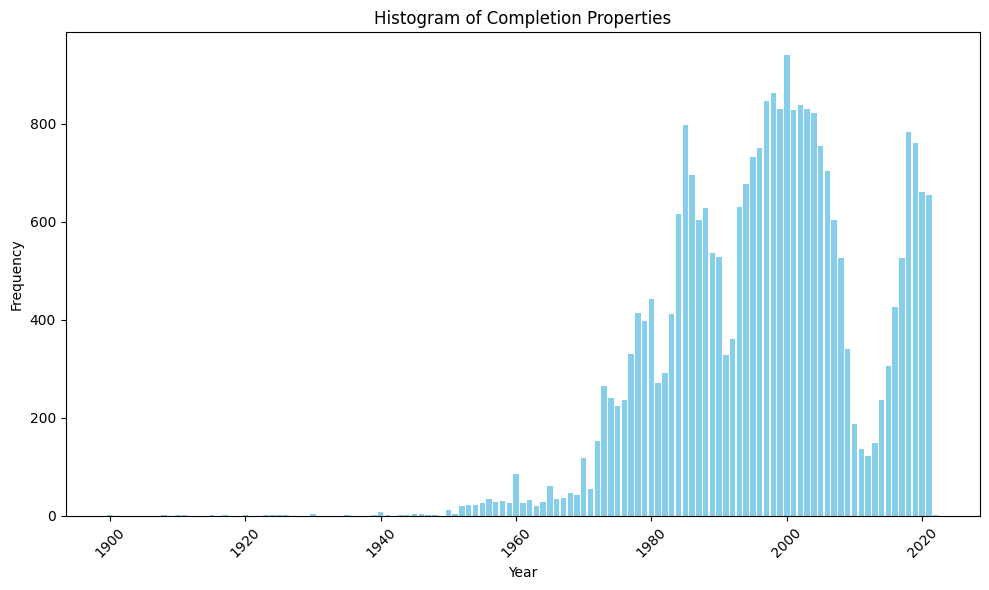

In [0]:
# Drawing a histogram showing the frequency of completion dates aggregated by year

df['CompletionDate'] = pd.to_datetime(df['CompletionDate'])
df['Year'] = df['CompletionDate'].dt.year
yearly_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Completion Properties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Three key observations from the histogram:
# 1. A significant gap exists around the 1990s, likely due to the impact of the Black Monday crisis in 1987.
# 2. Disruption around 2010, likely correlated with market turbulence due to the Subprime Mortgage Crisis in 2008.
# 3. Data availability is sparse before the 1970s, potentially due to limited data collection practices or historical record keeping.

In [0]:
# Counting occurrences for each decade to validate the observations
year_counts = df.groupby(df['Year'] // 10 * 10).size()
year_counts

Year
1900.0       2
1910.0       5
1920.0       8
1930.0       6
1940.0      20
1950.0     226
1960.0     415
1970.0    2432
1980.0    5297
1990.0    6548
2000.0    7187
2010.0    3636
2020.0    1318
dtype: int64

### While consulting domain experts is ideal, assumptions are made based on my understanding. 

###  Assumption 1: Column Definations

- `PropertyName`: The name or title assigned to the property.
- `Address`: The specific street address where the property is located.
- `City`: The municipality or urban area where the property is situated.
- `State`: The administrative division within a country where the property is located.
- `ZipCode`: The postal code assigned to the property's location.
- `PhoneNumber`: The contact phone number associated with the property.
- `TotalSqFt`: The total area in square feet encompassed by the property.
- `NetRentableSqFt`: The total leasable area in square feet within the property.
- `TotalAcres`: The overall land area of the property measured in acres.
- `NumBuildings`: The total count of buildings situated on the property.
- `NumFloors`: The number of floors or levels within the buildings on the property.
- `PropertyStatus`: The current status or condition of the property, such as active, pending, or sold.
- `ImpressionRating`: A qualitative assessment of the overall impression or aesthetic appeal of the property.
- `LocationRating`: An evaluation of the property's location or proximity to amenities, transportation, etc.
- `CompletionDate`: The date when the property construction or development was completed.


### Assumption 2: Interpretation of "ImpressionRating"

- "ImpressionRating" is likely sourced externally, such as from customer questionnaires or public rankings, reflecting public perception. It can be serve as a crucial evaluation metric for investment success.
- The ideal scenario is consistently achieving an "A" rating in future assessments. In other words, prioritizing a high ImpressionRating is essential for maximizing investment success by bolstering public reputation and property quality.

- The forthcoming analysis will center on classification techniques aimed at predicting ImpressionRating based on multiple dimensions. The objective is to elucidate factors influencing ImpressionRating and provide insights into its determinants.


## Part 2: Data Cleaning
- Filter out the years with insufficient data quality, keeping only the data from the desired timeframe
- Null/missing values handling

In [0]:
# Filter the dataset to keep only data after 1950 due to insufficient data quality before that period
df = df[df['Year'] >= 1950].reset_index(drop=True)

# Check null values in DataFrame 
print("Before dropping null values:\n", df.isna().sum())

# Drop null rows for specific columns: 'ZipCode', 'TotalAcres', 'LocationRating', and 'CompletionDate'df.dropna(subset=['ZipCode', 'TotalAcres', 'LocationRating', 'CompletionDate'], inplace=True)

# 'TotalSqFt' and 'NetRentableSqFt' are highly correlated and similar to each other
# Uncomment the following lines if you want to check the correlation between columns
# correlation_matrix = df[['TotalSqFt', 'NetRentableSqFt', 'TotalAcres']].corr()
# print(correlation_matrix)

# Fill missing values in 'TotalSqFt' and 'NetRentableSqFt' using each other's values
df['TotalSqFt'].fillna(df['NetRentableSqFt'], inplace=True)
df['NetRentableSqFt'].fillna(df['TotalSqFt'], inplace=True)

# Drop null rows for 'TotalSqFt' and 'NumBuildings' to maximize information retention
df.dropna(subset=['TotalSqFt', 'NumBuildings'], inplace=True)

print("After dropping null values:\n", df.isna().sum())

Before dropping null values:
 PropertyName          0
Address               0
City                  0
State                 0
ZipCode               0
PhoneNumber         394
TotalSqFt            18
NetRentableSqFt     382
TotalAcres            0
NumBuildings          9
NumFloors             0
PropertyStatus        0
ImpressionRating      0
LocationRating        0
CompletionDate        0
Year                  0
dtype: int64
After dropping null values:
 PropertyName          0
Address               0
City                  0
State                 0
ZipCode               0
PhoneNumber         386
TotalSqFt             0
NetRentableSqFt       0
TotalAcres            0
NumBuildings          0
NumFloors             0
PropertyStatus        0
ImpressionRating      0
LocationRating        0
CompletionDate        0
Year                  0
dtype: int64


## Part 3: Feature Engineering


### Feature 1: Property Name Categorization: 
Properties with counts of 500 or more are identified as big/popular property names.

In [0]:
# Calculate the counts of each property name
property_counts = df['PropertyName'].value_counts()

# Define the threshold for 'big' properties
threshold = 500  # Based on observation, retain information without having a sparse matrix

# Identify small properties below the threshold
small_property = property_counts[property_counts < threshold].index.tolist()

# Replace small property names with 'others'
df.loc[df['PropertyName'].isin(small_property), 'PropertyName'] = 'others'

# Print the counts of property names after categorization
print("Counts of Property Names after Categorization:")
print(df['PropertyName'].value_counts())

Counts of Property Names after Categorization:
others                       19289
Public Storage                2556
Extra Space Storage           1954
U - Haul Moving & Storage     1180
CubeSmart Self Storage        1162
LifeStorage                    896
Name: PropertyName, dtype: int64


### Feature 2: Population Mobility by City/State

1. Load Census data from the file "1790-2010_MASTER" and structure it by state and city, facilitating the calculation of population changes over decades and storage of results in dictionaries for further analysis.

2. Create new features, 'pop_mobility_city' and 'pop_mobility_state', by applying functions that assess population mobility at city and state levels. These features capture population mobility trends over time, offering insights into geographic mobility patterns within the dataset.

In [0]:
# Load population mobility data from Census records and map it by State and City
df_pop = pd.read_csv('1790-2010_MASTER.csv', sep=',', encoding='latin-1')

# Initialize dictionaries to store population changes for each state and city
state_city_population_changes = {}
state_population_changes = {}

# Group the DataFrame by state ('ST') column
grouped_by_state = df_pop.groupby('ST')

# Iterate over each state group
for state, state_group in grouped_by_state:
    # Initialize dictionary for the state and calculate population changes
    state_city_population_changes[state] = {}
    state_population_change = {}
    for i in range(20, 27):  # Assuming population data starts from column index 20 and ends at 27
        current_decade = int(state_group.columns[i])
        previous_decade = int(state_group.columns[i - 1])        
        state_population_change_ = (state_group[str(current_decade)] - state_group[str(previous_decade)]).sum()
        state_population_change[current_decade] = state_population_change_     
    state_population_changes[state] = state_population_change
    
    # Group the state group by city and calculate population changes
    grouped_by_city = state_group.groupby('City')
    for city, city_group in grouped_by_city:
        city_population_changes = {}
        for i in range(20, 27):  # Assuming population data starts from column index 20 and ends at 27
            current_decade = int(city_group.columns[i])
            previous_decade = int(city_group.columns[i - 1])
            population_change = (city_group[str(current_decade)] - city_group[str(previous_decade)]).values[0]
            city_population_changes[current_decade] = abs(population_change)
        state_city_population_changes[state][city] = city_population_changes

print("example of mobility dictionaries:")
print(state_city_population_changes['AK']['Anchorage'])
print(state_population_changes['AK'])

example of mobility dictionaries:
{1950: 7759.0, 1960: 32983.0, 1970: 3844.0, 1980: 126350.0, 1990: 51907.0, 2000: 33945.0, 2010: 31543.0}
{1950: 8425.0, 1960: 55994.0, 1970: 24704.0, 1980: 165464.0, 1990: 88007.0, 2000: 44302.0, 2010: 38845.0}


In [0]:
# Define functions to calculate population mobility at both city and state levels
def calculate_pop_mobility(row):
    state = row['State']
    city = row['City']        
    year = np.floor(row['Year'] / 10) * 10
    
    if state in state_population_changes and city in state_population_changes[state]:
        state_dict = state_population_changes[state]
        city_dict = state_dict[city]
        if year in city_dict:
            return city_dict[year]
    return None

def calculate_state_pop_mobility(row):
    state = row['State']
    year = np.floor(row['Year'] / 10) * 10
    
    if state in state_population_changes:
        state_dict = state_population_changes[state]
        if year in state_dict:
            return state_dict[year]
    return None

# Apply functions to create new features 'pop_mobility_city' and 'pop_mobility_state'
df['pop_mobility_city'] = df.apply(calculate_pop_mobility, axis=1)
df['pop_mobility_city'].fillna(0, inplace=True)

df['pop_mobility_state'] = df.apply(calculate_state_pop_mobility, axis=1)
df['pop_mobility_state'].fillna(0, inplace=True)

# Define numerical features for geographic mobility
geographic_features_num = ['pop_mobility_city', 'pop_mobility_state']

### Feature 3: Property Attributes

In [0]:
# Numerical property attribute features
property_attribute_features_num = ['TotalSqFt', 'TotalAcres', 'NumBuildings', 'NumFloors']

# Categorical property attribute features
property_attribute_features_cat = ['PropertyStatus']

### Feature 4: LocationRating Mapping

In [0]:
# The 'LocationRating' column represents ordinal categories with a meaningful order
# One-hot encoding would not capture this ordinal relationship, manual encoding instead.

# Define mapping for ordinal categories in 'LocationRating' column
LocationRating_mapping = {
    'NR': 0,  
    'C-': 1, 'C': 2, 'C+': 3,  
    'B-': 4, 'B': 5, 'B+': 6,  
    'A-': 7, 'A': 8, 'A+': 9  
}

# Map ordinal categories to numerical values based on the defined mapping
df['LocationRating'] = df['LocationRating'].map(LocationRating_mapping)

### Feature 5: Economoics Indicators - SP500 & DJones Indices from Yahoo Finance

In [0]:
# Fetch S&P 500 data from Yahoo Finance
sp500_data = yf.download('^GSPC', start=df['CompletionDate'].min(), end=df['CompletionDate'].max())[['Close']]

# Fetch DJIA data from Yahoo Finance
djia_data = yf.download('^DJI', start=df['CompletionDate'].min(), end=df['CompletionDate'].max())[['Close']]

# Merge S&P 500 and DJIA data into the main DataFrame
df = pd.merge_asof(df.sort_values('CompletionDate'), sp500_data, left_on='CompletionDate', right_index=True, direction='nearest')
df = pd.merge_asof(df.sort_values('CompletionDate'), djia_data, left_on='CompletionDate', right_index=True, direction='nearest')

# Rename the columns for clarity
df.rename(columns={'Close_x': 'SP500_Close', 'Close_y': 'DJIA_Close'}, inplace=True)

eco_features = ['SP500_Close', 'DJIA_Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Part 4: Data Preprocessing

In [0]:
# Define numerical and categorical features
num_features = property_attribute_features_num + eco_features + geographic_features_num
cate_feature = ['PropertyName'] + property_attribute_features_cat + ['LocationRating']

# Standardize the numerical features
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Perform one-hot encoding on categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[cate_feature])

# Combine numerical, economic, and encoded categorical features
all_features= np.concatenate([df[num_features].values, encoded_features], axis=1)

# Target variable
target = df['ImpressionRating']

# Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Sanity check
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

print("training data sample: ", X_train[0])

X_train shape: (16222, 27)
X_val shape: (5407, 27)
X_test shape: (5408, 27)
y_train shape: (16222,)
y_val shape: (5407,)
y_test shape: (5408,)
training data sample:  [0.31294491 0.02012402 0.96894082 0.4168217  0.47693114 0.28107013
 0.         0.10376621 0.         0.         0.         0.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.        ]


## Part 5: Model Selection and Validation

In this part, we'll explore classification algorithms including Decision Tree, Random Forest, XGBoost, K-Nearest Neighbors, and Support Vector Machine. Using 5-fold cross-validation, we'll evaluate these baseline models to identify the best-performing one(s). Our goal is to select the best model with the highest accuracy and the the strongest generalization to unseen data.

We'll assess model performance using the following evaluation metrics:
- **Accuracy**: Overall correctness of the model's predictions.
- **F1 Score (Micro, Macro)**: Harmonic mean of precision and recall, calculated across all classes.
- **Confusion Matrix**: A table showing the counts of true positive, true negative, false positive, and false negative predictions for each class.

In this use case, focusing solely on high or low ratings overlooks potential risks and fails to provide a holistic view. Our focus is on accurately predicting all credit ratings ('A' to 'C'), ensuring comprehensive risk assessment and informed investment decision-making.


In [0]:
# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42)
}

# Fit and transform the target variable y_val (xgb classifiers expect numeric labels for classification)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

# Evaluate each classifier using cross-validation
for name, clf in classifiers.items():
    cv_accuracy = cross_val_score(clf, X_train, y_train_encoded, cv=5, scoring='accuracy')
    cv_f1_micro = cross_val_score(clf, X_train, y_train_encoded, cv=5, scoring='f1_micro')
    cv_f1_macro = cross_val_score(clf, X_train, y_train_encoded, cv=5, scoring='f1_macro')

    # Compute predictions using cross-validation
    y_pred_cv = cross_val_predict(clf, X_val, y_val_encoded, cv=5)
    
    # Inverse transform the predictions to get original labels
    y_pred_cv_original = label_encoder.inverse_transform(y_pred_cv)
    
    # Calculate confusion matrix
    conf_matrix_cv = confusion_matrix(y_val, y_pred_cv_original)

    # Classification report
    class_report_cv = classification_report(y_val, y_pred_cv_original)
    
    # Print results
    print("")
    print(f"Classifier: {name}")
    print("Cross-Validation Accuracy:", cv_accuracy.mean())
    print("Cross-Validation F1 Score (Micro):", cv_f1_micro.mean())
    print("Cross-Validation F1 Score (Macro):", cv_f1_macro.mean())
    print("\nCross-Validation Confusion Matrix:")
    print(conf_matrix_cv)
    print("\nCross-Validation Classification Report:")
    print(class_report_cv)
    print("-----------------------------------------------------------")


Classifier: Decision Tree
Cross-Validation Accuracy: 0.6238431505170622
Cross-Validation F1 Score (Micro): 0.6238431505170622
Cross-Validation F1 Score (Macro): 0.7086530046677499

Cross-Validation Confusion Matrix:
[[ 634  306   65    0]
 [ 330 1231  607    3]
 [  57  612 1435    0]
 [   0    1    0  126]]

Cross-Validation Classification Report:
              precision    recall  f1-score   support

           A       0.62      0.63      0.63      1005
           B       0.57      0.57      0.57      2171
           C       0.68      0.68      0.68      2104
          NR       0.98      0.99      0.98       127

    accuracy                           0.63      5407
   macro avg       0.71      0.72      0.72      5407
weighted avg       0.63      0.63      0.63      5407

-----------------------------------------------------------

Classifier: Random Forest
Cross-Validation Accuracy: 0.7177902074518514
Cross-Validation F1 Score (Micro): 0.7177902074518514
Cross-Validation F1 Score (

Following the evaluation of various baseline models for the classification task, both the **Support Vector Machine (SVM)** and **Random Forest** emerged as top-performing models. Their superior precision, recall, and F1-scores across multiple metrics highlight their effectiveness in accurately classifying the target variable.

Moreover, both **SVM** and **Random Forest** demonstrated robust performance in handling class imbalances, as evidenced by their notable F1 Score (Micro) and F1 Score (Macro). This capability is particularly crucial in real-world scenarios where class distributions are often skewed.

Given their similar performance, both **SVM** and **Random Forest** will be selected for further fine-tuning to optimize their hyperparameters and potentially enhance their predictive performance.


## Part 6: Model Fine-tuning and Training

In [0]:
# Combine the training and validation sets to create a new training set for model fine-tuning.
# Note: The original test set (X_test and y_test) remains untouched, serving as holdout data for evluatiuon stage.

# Concatenate features of training and validation sets
X_new_train = np.concatenate((X_train, X_val), axis=0)

# Concatenate labels of training and validation sets
y_new_train = np.concatenate((y_train, y_val), axis=0)

# Sanity check
print("X_new_train shape:", X_new_train.shape)
print("y_new_train shape:", y_new_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_new_train shape: (21629, 27)
y_new_train shape: (21629,)
X_test shape: (5408, 27)
y_test shape: (5408,)


### Fine-tune 1: Support Vector Machine

In [0]:
# # Define the parameter grid for SVM
# param_grid_svm = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma': [1e-3, 1e-2, 0.1, 1, 10]
# }

# # Instantiate the SVM classifier with the RBF kernel
# svm = SVC(kernel='rbf')

# # Instantiate GridSearchCV with the parameter grid and parallel execution
# grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search_svm.fit(X_new_train, y_new_train)

# # Retrieve best parameters
# best_params_svm = grid_search_svm.best_params_

# # Print the best parameters
# print("Best Parameters (SVM):", best_params_svm)

After conducting a thorough grid search, the optimal hyperparameters for SVM is

{'C': 1, 'gamma': 0.1}

In [0]:
best_params_svm = {'C': 1, 'gamma': 0.1}

### Fine-tune 2: Random Forest

In [0]:
# # Define the expanded parameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 6, 8],
# }

# # Instantiate the Random Forest classifier
# rf = RandomForestClassifier(random_state=42)

# # Instantiate GridSearchCV for Random Forest with expanded grid
# grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV for Random Forest with expanded grid
# grid_search_rf.fit(X_new_train, y_new_train)

# # Retrieve best parameters for Random Forest with expanded grid
# best_params_rf = grid_search_rf.best_params_

# # Print the best parameters for Random Forest with expanded grid
# print("Best Parameters for Random Forest:", best_params_rf)


After conducting a thorough grid search, the optimal hyperparameters for Random Forest is 

{'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}


In [0]:
best_params_rf = {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}

## Part 7: Model Evaluation

In this section, we evaluate the performance of the fine-tuned Support Vector Machine classifier and Random Forest classifier using the holdout set (X_test and y_test). It is ensured that no data leakage occurs during the evaluation process, maintaining the integrity of the evaluation results.

### Evaluation 1: Fine-tuned SVM 

In [0]:
# Initialize SVM classifier with best parameters
best_svm = SVC(C=1, gamma=0.1, random_state=42, kernel='rbf')

# Fit SVM classifier on the training data
best_svm.fit(X_new_train, y_new_train)

# Generate predictions on the test set using the SVM classifier
y_pred_test_svm = best_svm.predict(X_test)

# Calculate evaluation metrics for the SVM classifier
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
precision_svm = precision_score(y_test, y_pred_test_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_test_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_test_svm, average='weighted')

# Print the evaluation metrics for the SVM classifier
print("Test Accuracy (SVM):", test_accuracy_svm)
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1 Score (SVM):", f1_svm)

# Generate confusion matrix for the SVM classifier
print("\nConfusion Matrix (SVM):")
print(confusion_matrix(y_test, y_pred_test_svm))

# Generate classification report for the SVM classifier
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_test_svm))
print("---------------------------------------——————————————————————")

Test Accuracy (SVM): 0.7283653846153846
Precision (SVM): 0.7271665348651324
Recall (SVM): 0.7283653846153846
F1 Score (SVM): 0.7274380581997286

Confusion Matrix (SVM):
[[ 803  199   21    1]
 [ 229 1450  539    0]
 [  22  456 1574    1]
 [   1    0    0  112]]

Classification Report (SVM):
              precision    recall  f1-score   support

           A       0.76      0.78      0.77      1024
           B       0.69      0.65      0.67      2218
           C       0.74      0.77      0.75      2053
          NR       0.98      0.99      0.99       113

    accuracy                           0.73      5408
   macro avg       0.79      0.80      0.80      5408
weighted avg       0.73      0.73      0.73      5408

---------------------------------------——————————————————————


The evaluation of the Support Vector Machine (SVM) classifier reveals a respectable performance, with an overall test accuracy of approximately 72.84%. Precision, recall, and F1 scores demonstrate consistent performance across classes. Due to time constraints, more complex kernels, such as “poly”, were not explored, and based on experimentation with baseline models, the RBF kernel was deemed most suitable for this case. 

Overall, SVM yielded promising results. If resources permit, delving into more sophisticated feature engineering methodologies holds the potential to further enhance the model's performance.

### Evaluation 2: Fine-tuned RandomForest

In [0]:
# Initialize RandomForestClassifier with best parameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=42)

# Fit the RandomForestClassifier on the training data
best_rf.fit(X_new_train, y_new_train)

# Generate predictions on the test set using the RandomForestClassifier
y_pred_test = best_rf.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

# Print the evaluation metrics
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print("---------------------------------------——————————————————————")

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 0.735207100591716
Precision: 0.7348275684422649
Recall: 0.735207100591716
F1 Score: 0.7349887025200543

Confusion Matrix:
[[ 808  201   14    1]
 [ 226 1507  485    0]
 [  14  489 1549    1]
 [   1    0    0  112]]

Classification Report:
              precision    recall  f1-score   support

           A       0.77      0.79      0.78      1024
           B       0.69      0.68      0.68      2218
           C       0.76      0.75      0.76      2053
          NR       0.98      0.99      0.99       113

    accuracy                           0.74      5408
   macro avg       0.80      0.80      0.80      5408
weighted avg       0.73      0.74      0.73      5408

---------------------------------------——————————————————————


Based on the analysis of the Random Forest classifier's evaluation metrics, it demonstrates excellent performance, achieving an overall test accuracy of approximately 73.52%. Precision, recall, and F1 scores exhibit consistent performance across classes. Unlike the Support Vector Machine (SVM) classifier, the faster computation time for Random Forest's grid search makes thorough hyperparameter tuning feasible.

Overall, the Random Forest model's performance surpasses that of the SVM classifier, with a higher test accuracy by approximately 0.7%, suggesting its potential for further deployment. Similarly, if resources permit, delving into more sophisticated feature engineering methodologies holds the potential to further enhance the model's performance.

## Part 8: Model Interpretation

To interpret the features, I opted to utilize the Random Forest model post-training. This choice was primarily motivated by its inherent feature importance function, which offers a straightforward approach to understanding the model. Additionally, the complex nature of Support Vector Machines (SVMs) poses challenges in deciphering feature importance, despite attempted methods. Due to time constraints, exhaustive exploration of all methods for interpreting SVM models wasn't feasible, as discussed in the "Challenges and Limitations" section.

I employed two main methods to interpret the features of the Random Forest model:
1. **Built-in Feature Importance**: Leveraging the Random Forest's built-in feature importance functionality.
2. **SHAP (SHapley Additive exPlanations)**: Utilizing the SHAP library, a widely used feature explanation tool.

These methods were chosen to offer a comprehensive understanding of feature importance. Subsequently, I provided conjectures along with practical business implications regarding feature importance.


### 1. Built-in Feature Importance

In [0]:
# retriev the feature names 
numerical_feature_names = num_features
encoded_categorical_feature_names = encoder.get_feature_names_out(input_features=cate_feature)
all_feature_names = np.concatenate([numerical_feature_names, encoded_categorical_feature_names])
print(all_feature_names[:5])

['TotalSqFt' 'TotalAcres' 'NumBuildings' 'NumFloors' 'SP500_Close']


In [0]:
feature_importance = best_rf.feature_importances_

# Create a DataFrame to associate feature importance values with column names
rf_feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})
rf_feature_importance = rf_feature_importance.sort_values('Importance', ascending = False)

# Display the top 10 importance fatrues
rf_feature_importance.reset_index(drop = True).head(10)

,Feature,Importance
0,TotalSqFt,0.184108
1,NumFloors,0.175815
2,SP500_Close,0.133907
3,DJIA_Close,0.130864
4,TotalAcres,0.077365
5,NumBuildings,0.067186
6,pop_mobility_state,0.066812
7,PropertyName_others,0.047685
8,PropertyStatus_Under Construction,0.026654
9,PropertyStatus_Completed,0.025460


### Interpretations of key features:

1. **TotalSqFt (0.184108) and NumFloors (0.175815):**
   - Larger storage facilities with more floors can accommodate more goods, attracting tenants who require significant storage space. This increased capacity and flexibility can lead to higher demand and, consequently, higher rental rates.


2. **SP500_Close (0.133907) and DJIA_Close (0.130864):**
   - Economic stability and growth, reflected in the performance of indices like the S&P 500 and Dow Jones Industrial Average, often correlate with increased demand for storage space. Businesses expanding their operations or individuals moving due to economic factors may require storage facilities, impacting rental rates.


3. **TotalAcres (0.077365) and NumBuildings (0.067186):**
   - Similarly, larger total acres and more buildings within a storage facility complex indicate a larger overall capacity and variety of storage options. This versatility appeals to a broader range of tenants, potentially increasing demand and rental rates.


4. **pop_mobility_state (0.066812):**
   - Population mobility at the state level may reflect economic activity and population growth within a region. Increased mobility can lead to more businesses relocating or individuals moving, potentially driving up demand for storage space and influencing rental rates.


5. **PropertyName_others (0.047685):**
   - The inclusion of various storage facility brands not explicitly listed suggests that brand or reputation could also impact rental rates. Well-known brands or facilities with a positive reputation may command higher rental rates due to perceived quality or trustworthiness.


### 2. SHAP Value Calculation
Due to computational constraints, a random subset of 100 samples was chosen for SHAP (SHapley Additive exPlanations) value calculation. While this subset strikes a balance between computational cost and analysis depth, larger subsets may offer more comprehensive insights into feature importance. After all, due to random sampling,  this subset is expected to be somewhat representative of the overall dataset.

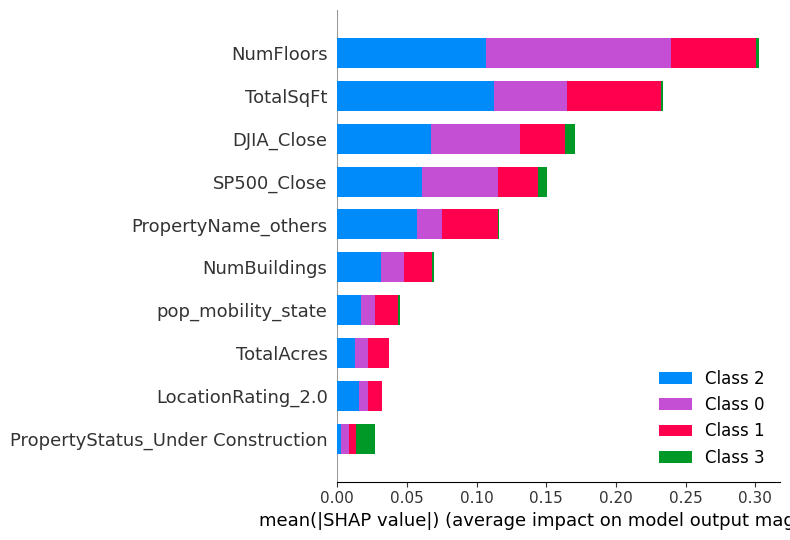

In [0]:
# Select a random subset of 100 samples
random_indices = np.random.choice(X_new_train.shape[0], 100, replace=False)
X_subset = X_new_train[random_indices]

# Compute SHAP values
explainer = shap.TreeExplainer(best_rf)
shap_values_subset = explainer.shap_values(X_subset)

# Map the feature names with SHAP values
shap.summary_plot(shap_values_subset, X_subset, feature_names=all_feature_names, max_display = 10, plot_type="bar",)

The visualization above, derived from the SHAP (SHapley Additive exPlanations) value calculation, aligns with the built-in feature importance. This consistency indicates reliability in the interpretation of feature importance.

## Part 9: Challenges and Limitations

### 1. **Assumption Validation:** 
 - Ensuring logical and correct assumptions, including column definitions, is critical for this use case. Lack of business domain knowledge underscores the need for consultation with domain experts to establish these assumptions collaboratively in real-world scenarios.


### 2. **Geographical Data Utilization Limitation:** 
 - I utilized census population statistics to calculate population mobility, mapping it as a feature in my dataset. However, ertain cities were not adequately covered by the data. I noticed that some premium datasets offer more standardized structures and broader data coverage, potentially addressing these gaps. Additionally, while merging data, I relied on city and state names. Utilizing zip codes for mapping in premium datasets could offer a more accurate and convenient approach, enhancing scalability and sustainability.


### 3. **Time Constraint Challenges:** 
 - Due to time constraints, I was unable to explore an extensive grid search during the fine-tuning process. Instead, I relied on my experience to narrow down the parameter space. Furthermore, I selected conventional models for experimentation to expedite the process. However, a more detailed examination of internal data relationships and feature engineering might warrant the application of more complex classification models such as Neural Networks, which is possible to uncover latent patterns within the data, potentially leading to enhancements in performance.
 

### 4. **Model Interpretation Challenges:**
 - The nature of Support Vector Machine (SVM) models poses challenges in interpretation due to their inherent black-box nature. Attempts were made to utilize the SHAP library to approximate feature importances. However, processing SHAP values took an impractical amount of time. Given more time, an alternative approach would involve training a baseline SVM model separately and manually reducing dimensionality by selecting only the most crucial features for training. This approach would streamline the process of computing SHAP values, making it more efficient and feasible for interpretation purposes.


   




## Part 10: Conclusion

Firstly, I successfully conducted **Exploratory Data Analysis (EDA)** on the dataset, **engineered features** from existing columns, and **merged two external datasets** based on timestamps and geographical locations to create new features. From my model pool, I selected **Support Vector Machine (SVM)** and **Random Forest** as candidate models for further **grid search fine-tuning**. Each model's performance was assessed using **cross-validation** to avoid overfitting. Finally, I evaluated the models using holdout data and interpreted their outputs based on **feature importance**. The **classification accuracy** of the two models reached **72.8% and 73.5%**, respectively. Given the limited time and my lack of extensive background knowledge of the dataset, I consider this performance satisfactory.

Further improvements in **feature engineering** could be made after the consultation with business domain experts. The next steps involve **model deployment** and implementing a series of **MLOps operations** such as **model monitoring, automation, and drift detection**.

I am grateful for the opportunity provided, and I found working on this project to be enjoyable. I am enthusiastic about conducting similar projects in the future. Thank you for taking the time to review. Have a good day~!
